In [2]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import seaborn

In [4]:
#global variables --- same as CDC paper for small players
x_bar = 1.0   #maximum consumption
noise_var = 1.0    #variance of noise values
g = np.arange(0,1.1,0.1)  #discretization of space of power consumption values x \in [0,\bar{x}]
s_vals = np.arange(-2.0,2.0,0.1)  #discretization of space of noise values, 98% of normal distribution with unit variance
samples = np.random.normal(0, noise_var, size=100000)
s_hist = np.histogram(samples, bins=np.arange(-2.0,2.1,0.1), normed=True)[0]
s_hist = (1.0/np.linalg.norm(s_hist, ord=1)) * s_hist #probabilities over discretized noise values
ramp_const = 0.3  #time coupling ramping constraint
pi_cp_perc = 0.6  #ratio of pi_cp cost to total utility under a naive fixed strategy

net_params = {'FEATURE_DIM': 4, 'OUTPUT_DIM': 1, 'HIDDEN_1': 16}

base_path = "/home/chase/projects/peakload/notebooks/" #change this to path to notebook + data


T = 10

In [12]:
#functions 

def player_return(utility_func, plays, system_vals, pi_cp):
    indicator_vec = vec_softmax(system_vals)
    cp_cost = pi_cp*(plays*indicator_vec)
    rev = np.sum(utility_func(plays))
    out = rev - cp_cost
    return(out)

def vec_softmax(system_vals, beta=20):
    #system_vals must be numpy array
    if type(np.array([1])) != np.ndarray:
        print("System values not numpy array")
    else:
        #large beta approximates argmax indicator vector
        numer = np.exp(beta*system_vals)
        denom = np.sum(np.exp(beta*system_vals))
        out = (1.0/denom)*numer
        return(out)
    
def player_utility_lambda(a=1):
    return(lambda x: a*np.log(1 + x))

def player_d_utility_lambda(a=1):
    return(lambda x: a/(1 + x))

def player_dd_utility_lambda(a=1):
    return(lambda x: -a/np.power(1 + x, 2))

In [6]:
xs = np.arange(0,1,0.01)
ys = np.arange(0,1,0.01)
outvals = []

X, Y = np.meshgrid(xs,ys)

In [7]:
X

array([[0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       ...,
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99]])

In [10]:
Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        xi = X[i,j]
        yi = Y[i,j]
        out_val = xi*vec_softmax(np.array([xi, yi]))[0] + yi*vec_softmax(np.array([xi, yi]))[-1]
        Z[i,j] = out_val

<IPython.core.display.Javascript object>


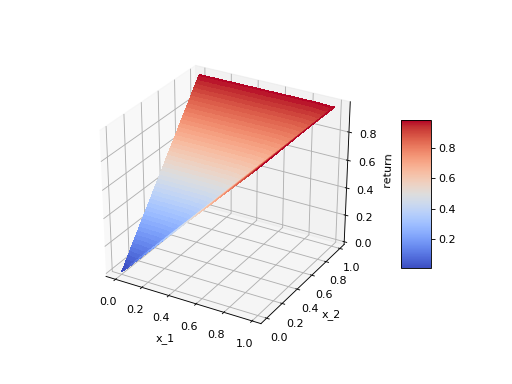

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("x_1")
ax.set_ylabel("x_2")
ax.set_zlabel("return")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

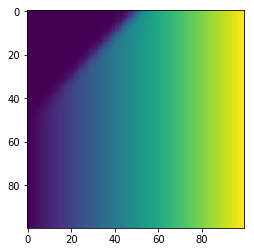

In [28]:
#plot for 3 different values of y

y = 0.1

<IPython.core.display.Javascript object>


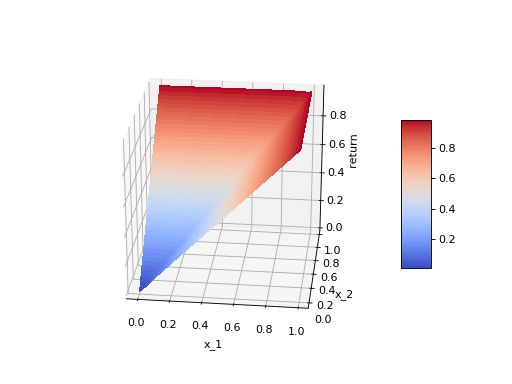

In [12]:
#plot for fixed 

y = 0.5

Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        xi = X[i,j]
        yi = Y[i,j]
        out_val = xi*vec_softmax(np.array([xi+y, yi+y]))[0] + yi*vec_softmax(np.array([xi+y, yi+y]))[-1]
        Z[i,j] = out_val
        
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("x_1")
ax.set_ylabel("x_2")
ax.set_zlabel("return")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [13]:
p1 = player_utility_lambda()

<IPython.core.display.Javascript object>


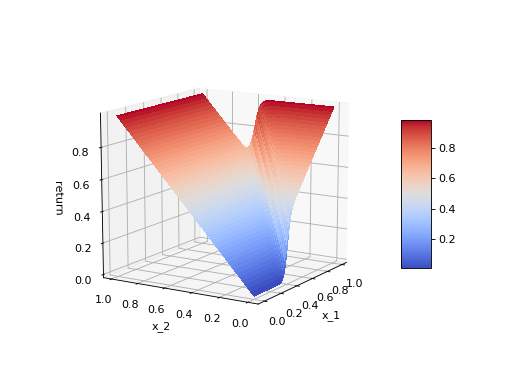

In [14]:
#plot for random y

y1 = 0.4#np.random.uniform(0,1)
y2 = 0.8#np.random.uniform(0,1)

Z = np.zeros(X.shape)

Z_rev = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        xi = X[i,j]
        yi = Y[i,j]
        out_val = xi*vec_softmax(np.array([xi+y1, yi+y2]))[0] + yi*vec_softmax(np.array([xi+y1, yi+y2]))[-1]
        Z[i,j] = out_val
        Z_rev[i,j] = np.abs(-1.0*p1(xi)) + np.abs(-1.0*p1(yi)) - out_val
        
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("x_1")
ax.set_ylabel("x_2")
ax.set_zlabel("return")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>


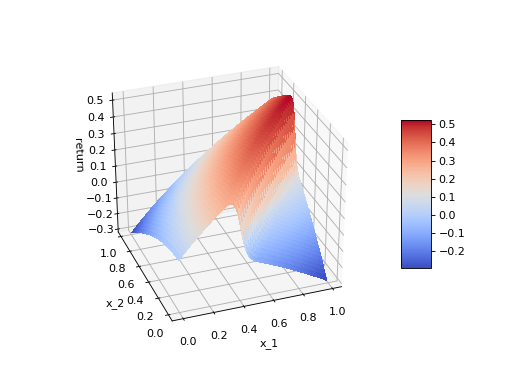

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z_rev, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("x_1")
ax.set_ylabel("x_2")
ax.set_zlabel("return")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>


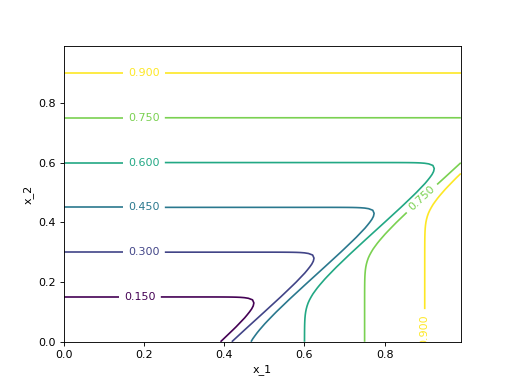

In [16]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
plt.xlabel("x_1")
plt.ylabel("x_2")

plt.show()

In [60]:
print(y1, y2)

0.2 0.8


In [8]:
A = np.array([[1,1],
              [0,1]])

np.argwhere(A>=1)

array([[0, 0],
       [0, 1],
       [1, 1]])

In [10]:
A[np.argwhere(A>=1)[:,0], np.argwhere(A>=1)[:,1]]

array([1, 1, 1])

In [20]:
# draw best response curves

#for each y_1, y_2, find max of -softmax


#plot for random y

#just for softmax

y1s = np.arange(0,1.5,0.05)
y2s = np.arange(0,1.5,0.05)

x1s = np.arange(0,1.5,0.05)
x2s = np.arange(0,1.5,0.05)
outvals = []
plays = []

X, Y = np.meshgrid(x1s,x2s)

x_best_response = np.zeros((y1s.shape[0], y2s.shape[0]))

for i in range(y1s.shape[0]):
    for j in range(y2s.shape[0]):
        if i % 5 == 0 and j % 5 == 0:
            print(i,j)
        y1 = y1s[i]
        y2 = y2s[j]
        Z = np.zeros(X.shape)

        #Z_rev = np.zeros(X.shape)

        for k in range(X.shape[0]):
            for l in range(X.shape[1]):
                x1 = X[k,l]
                x2 = Y[k,l]
                out_val = -1.0 *(x1*vec_softmax(np.array([x1+y1, x2+y2]))[0] + x2*vec_softmax(np.array([x1+y1, x2+y2]))[-1])
                Z[k,l] = out_val
                #Z_rev[i,j] = np.abs(-1.0*p1(xi)) + np.abs(-1.0*p1(yi)) - out_val
        max_val = np.max(Z)
        vals = Z[np.argwhere(Z>=max_val)[:,0], np.argwhere(Z>=max_val)[:,1]]
        
        plays.append(np.argwhere(Z>=max_val))
        outvals.append(vals)

0 0
0 5
0 10
0 15
0 20
0 25
5 0
5 5
5 10
5 15
5 20
5 25
10 0
10 5
10 10
10 15
10 20
10 25
15 0
15 5
15 10
15 15
15 20
15 25
20 0
20 5
20 10
20 15
20 20
20 25
25 0
25 5
25 10
25 15
25 20
25 25


In [22]:
plays

[array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0, 0]]),
 array([[0

In [29]:
# draw best response curves

#for each y_1, y_2, find max of -softmax


#plot for random y

#just for softmax

y1s = np.arange(0,1.5,0.05)
y2s = np.arange(0,1.5,0.05)

x1s = np.arange(0,1.5,0.05)
x2s = np.arange(0,1.5,0.05)
outvals = []
plays = []

pi_cp = 1.2

p1 = player_utility_lambda()

X1, X2 = np.meshgrid(x1s,x2s)

x_best_response = np.zeros((y1s.shape[0], y2s.shape[0]))

for i in range(y1s.shape[0]):
    for j in range(y2s.shape[0]):
        if i % 5 == 0 and j % 5 == 0:
            print(i,j)
        y1 = y1s[i]
        y2 = y2s[j]
        Z = np.zeros(X.shape)

        #Z_rev = np.zeros(X.shape)

        for k in range(X1.shape[0]):
            for l in range(X2.shape[1]):
                x1 = X1[k,l]
                x2 = X2[k,l]
                out_val = -1.0 * pi_cp * (x1*vec_softmax(np.array([x1+y1, x2+y2]))[0] + x2*vec_softmax(np.array([x1+y1, x2+y2]))[-1])
                
                Z[k,l] = p1(x1) + p1(y2) + out_val
                
        max_val = np.max(Z)
        vals = Z[np.argwhere(Z>=max_val)[:,0], np.argwhere(Z>=max_val)[:,1]]
        
        plays.append(([y1, y2], np.argwhere(Z>=max_val)))
        outvals.append(vals)

0 0
0 5
0 10
0 15
0 20
0 25
5 0
5 5
5 10
5 15
5 20
5 25
10 0
10 5
10 10
10 15
10 20
10 25
15 0
15 5
15 10
15 15
15 20
15 25
20 0
20 5
20 10
20 15
20 20
20 25
25 0
25 5
25 10
25 15
25 20
25 25


In [30]:
plays

[([0.0, 0.0], array([[0, 0]])),
 ([0.0, 0.05], array([[0, 1]])),
 ([0.0, 0.1], array([[0, 1]])),
 ([0.0, 0.15000000000000002], array([[0, 2]])),
 ([0.0, 0.2], array([[0, 3]])),
 ([0.0, 0.25], array([[0, 4]])),
 ([0.0, 0.30000000000000004], array([[0, 5]])),
 ([0.0, 0.35000000000000003], array([[0, 6]])),
 ([0.0, 0.4], array([[0, 7]])),
 ([0.0, 0.45], array([[0, 8]])),
 ([0.0, 0.5], array([[0, 8]])),
 ([0.0, 0.55], array([[0, 9]])),
 ([0.0, 0.6000000000000001], array([[ 0, 10]])),
 ([0.0, 0.65], array([[ 0, 11]])),
 ([0.0, 0.7000000000000001], array([[ 0, 12]])),
 ([0.0, 0.75], array([[ 0, 13]])),
 ([0.0, 0.8], array([[ 0, 14]])),
 ([0.0, 0.8500000000000001], array([[ 0, 15]])),
 ([0.0, 0.9], array([[ 0, 16]])),
 ([0.0, 0.9500000000000001], array([[ 0, 17]])),
 ([0.0, 1.0], array([[ 0, 18]])),
 ([0.0, 1.05], array([[ 0, 19]])),
 ([0.0, 1.1], array([[ 0, 20]])),
 ([0.0, 1.1500000000000001], array([[ 0, 21]])),
 ([0.0, 1.2000000000000002], array([[ 0, 22]])),
 ([0.0, 1.25], array([[ 0, 23

In [35]:
outvals

[array([0.]),
 array([0.06758033]),
 array([0.13954885]),
 array([0.22596914]),
 array([0.30842903]),
 array([0.38725914]),
 array([0.46275036]),
 array([0.53515991]),
 array([0.60471639]),
 array([0.67162387]),
 array([0.73872478]),
 array([0.80620435]),
 array([0.87145303]),
 array([0.93461294]),
 array([0.99581303]),
 array([1.05517065]),
 array([1.11279292]),
 array([1.16877786]),
 array([1.22321541]),
 array([1.2761883]),
 array([1.32777279]),
 array([1.37803932]),
 array([1.4270531]),
 array([1.47487464]),
 array([1.52156014]),
 array([1.56716192]),
 array([1.61172878]),
 array([1.65530627]),
 array([1.69793701]),
 array([1.73966093]),
 array([0.]),
 array([0.04879016]),
 array([0.11410034]),
 array([0.18400062]),
 array([0.26852875]),
 array([0.34925102]),
 array([0.42647986]),
 array([0.50049069]),
 array([0.57152756]),
 array([0.63980771]),
 array([0.70552542]),
 array([0.7715146]),
 array([0.83795305]),
 array([0.90222469]),
 array([0.9644659]),
 array([1.02480056]),
 array([